# Imports

In [2]:
import pandas as pd
import numpy as np
import sys

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Load Data 

In [3]:
df = pd.read_csv('./datasets/titanic/train.csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Missing Data

In [5]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Remove the 'Cabin' column as these values will be impossible to recover

In [6]:
df = df.drop('Cabin', axis=1)
df.shape

(891, 11)

### Replace missing age values with the mean age of the entire passenger list

In [7]:
df['Age'].fillna(df.Age.mean(), inplace=True)
df.shape

(891, 11)

### Replace missing 'embarked' values with the most frequently occurring

In [8]:
embarked = df['Embarked'].copy()
embarked_freq = embarked.value_counts()
embarked_freq

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [9]:
df['Embarked'].fillna(value='S', inplace=True)

In [10]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

# Plot Data

In [11]:
male_surv = len(df[(df.Sex == 'male') & (df.Survived == 1)])
male_dead = len(df[(df.Sex == 'male') & (df.Survived == 0)])
female_surv = len(df[(df.Sex == 'female') & (df.Survived == 1)])
female_dead = len(df[(df.Sex == 'female') & (df.Survived == 0)])

male_s_rate = male_surv / float(male_surv + male_dead)
female_s_rate = female_surv / float(female_surv + female_dead)

print(female_s_rate, male_s_rate) 

0.7420382165605095 0.18890814558058924


### Age Distribution (Within Genders)

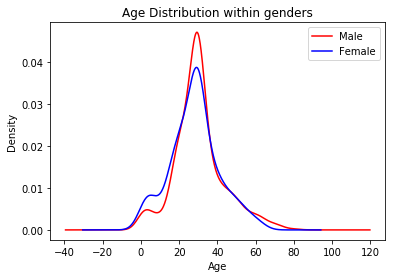

In [12]:
% matplotlib inline 

colors = ['r', 'b', 'g']

df.Age[df.Sex == 'male'].plot(kind='kde', color=colors[0])    
df.Age[df.Sex == 'female'].plot(kind='kde', color=colors[1])

plt.xlabel("Age")    
plt.title("Age Distribution within genders")
plt.legend(('Male', 'Female'),loc='best')

### Age Distribution (Within Classes)

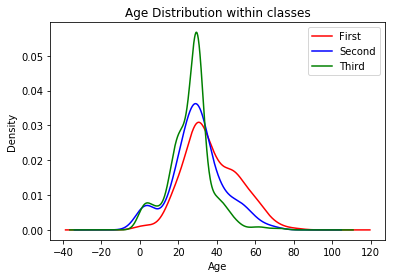

In [13]:
df.Age[df.Pclass == 1].plot(kind='kde', color=colors[0])
df.Age[df.Pclass == 2].plot(kind='kde', color=colors[1])
df.Age[df.Pclass == 3].plot(kind='kde', color=colors[2])

plt.xlabel("Age")    
plt.title("Age Distribution within classes")
plt.legend(('First', 'Second', 'Third'),loc='best')

### Age Distribution (among those who survived and those who did not)

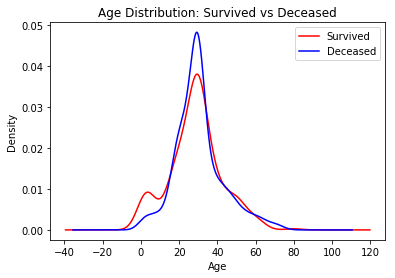

In [14]:
df.Age[df.Survived == 1].plot(kind='kde', color=colors[0])
df.Age[df.Survived == 0].plot(kind='kde', color=colors[1])

plt.xlabel("Age")    
plt.title("Age Distribution: Survived vs Deceased")
plt.legend(('Survived', 'Deceased'),loc='best')

# Copy data

In [15]:
X = pd.get_dummies(df, columns=['Sex', 'Embarked'])

In [16]:
X.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

# Clean Data

In [17]:
X = X.dropna(axis=0)
y = X.Survived
X = X.drop('Survived', axis=1)

all_cols = X.columns
non_features = ['PassengerId', 'Name', 'Ticket']
features = list(set(all_cols) - set(non_features))

# Scripts

In [18]:
def cross_validate_models(models, X, y):
    ret = []
    score_metrics = ['f1_macro', 'roc_auc', 'accuracy']
    total_number_evals = len(models) * len(score_metrics)
    
    for name, model in models:
        for metric in score_metrics:
            started = len(ret)
            print_status_bar(total_number_evals, started + 1)
            
            scores = cross_val_score(model, X, y, cv=5, scoring=metric)
            ret.append({'Classifier': name, 'Score_Metric': metric, 
                        'Mean_Score': scores.mean(), '95%_Conf_Interval': scores.std() * 2})
            
    print('\n')
    
    return ret

def eval_models(models, X, y):
    X_train, X_test, y_train, y_test = get_train_test_split(X, y)
    
    ret = []
    print_status_bar(len(models), len(ret))
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for name, model in models:
        precision, recall, f1 = train_and_get_scores(model, X_train_scaled, y_train, X_test_scaled, y_test)
        ret.append({'Precision': precision, 'Recall': recall, 'F1_Score': f1, 'Classifier': name})
        print_status_bar(len(models), len(ret))
    print('\n')
    
    return ret

def get_train_test_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

def train_and_get_scores(model, X_train, y_train, X_test, y_test, verbose=False):
    model = model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    prec = precision_score(y_test, y_pred)
    recl = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return prec, recl, f1
    
    
def print_status_bar(bar_length, filled_length):
    bar = '=' * filled_length + '-' * (bar_length - filled_length)
    sys.stdout.write('\r[%s]' % bar)
    sys.stdout.flush()

# Models Under Evaluation

In [97]:
gbm0 = GradientBoostingClassifier()

gbm1 = GradientBoostingClassifier(loss='exponential',
                                  learning_rate=0.01,
                                  n_estimators=1000,
                                  max_depth=4)

gbm2 = GradientBoostingClassifier(loss='deviance',
                                  learning_rate=0.01,
                                  n_estimators=2000,
                                  max_depth=3)

gbm3 = GradientBoostingClassifier(loss='deviance',
                                  learning_rate=0.01,
                                  n_estimators=1000,
                                  max_depth=3)

gbm4 = GradientBoostingClassifier(loss='exponential',
                                  learning_rate=0.01,
                                  n_estimators=500,
                                  max_depth=4,
                                  subsample=0.3,
                                  max_features='sqrt')

models = [# ('LogisticRegression', LogisticRegression()), 
          # ('LinearSVM', LinearSVC()), 
          # ('SVC', SVC()),
          # ('DecisionTreeClassifier', DecisionTreeClassifier()),
          ('RandomForestClassifier', RandomForestClassifier()),
          ('GradientBoostingClassifier0', gbm0),
          ('GradientBoostingClassifier1', gbm1),
          ('GradientBoostingClassifier2', gbm2),
          ('GradientBoostingClassifier3', gbm3),
          ('GradientBoostingClassifier4', gbm4),]

# Test

In [98]:
results_df = pd.DataFrame(cross_validate_models(models, X[features], y))

[==================]



In [99]:
results_cp = results_df.copy()
results_cp = results_cp[['Classifier', 
                         'Score_Metric', 
                         'Mean_Score', 
                         '95%_Conf_Interval']].sort_values(by='Mean_Score').groupby('Score_Metric')
results_cp

In [100]:
results_cp.head(n=100)

,Classifier,Score_Metric,Mean_Score,95%_Conf_Interval
0,RandomForestClassifier,f1_macro,0.799994,0.053593
2,RandomForestClassifier,accuracy,0.803708,0.078176
3,GradientBoostingClassifier0,f1_macro,0.804939,0.043049
15,GradientBoostingClassifier4,f1_macro,0.805363,0.051622
12,GradientBoostingClassifier3,f1_macro,0.809293,0.044345
9,GradientBoostingClassifier2,f1_macro,0.812121,0.048423
6,GradientBoostingClassifier1,f1_macro,0.819544,0.036472
5,GradientBoostingClassifier0,accuracy,0.820493,0.036991
17,GradientBoostingClassifier4,accuracy,0.822702,0.035961
14,GradientBoostingClassifier3,accuracy,0.824968,0.038210


In [26]:
results_df2 = pd.DataFrame(eval_models(models, X[features], y))

[=====]



In [27]:
results_df2 = results_df2.sort_values('F1_Score')
results_df2

,Classifier,F1_Score,Precision,Recall
4,GradientBoostingClassifier4,0.728033,0.731092,0.725000
0,RandomForestClassifier,0.735426,0.796117,0.683333
3,GradientBoostingClassifier3,0.746544,0.835052,0.675000
1,GradientBoostingClassifier1,0.752212,0.801887,0.708333
2,GradientBoostingClassifier2,0.755556,0.809524,0.708333


# Predict Test Data

In [101]:
gbm1 = GradientBoostingClassifier(loss='exponential',
                                  learning_rate=0.01,
                                  n_estimators=1000,
                                  max_depth=4)

gbm3 = GradientBoostingClassifier(loss='deviance',
                                  learning_rate=0.01,
                                  n_estimators=1000,
                                  max_depth=3)

clf = gbm1.fit(X[features], y)

In [102]:
df_test = pd.read_csv('./datasets/titanic/test.csv')

In [103]:
df_test = df_test.drop('Cabin', axis=1)
df_test['Age'].fillna(df_test.Age.mean(), inplace=True)

In [104]:
df_test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
dtype: int64

In [105]:
df_test['Fare'].fillna(df_test.Fare.mean(), inplace=True)
df_test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [106]:
X_test = pd.get_dummies(df_test, columns=['Sex', 'Embarked'])

In [107]:
#X_test = X_test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
X_test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [108]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
            'Embarked_S']

In [109]:
y_test_results = pd.DataFrame([X_test['PassengerId'], clf.predict(X_test[features])], index=['PassengerId', 'Survived'])

In [110]:
y_test_results = y_test_results.transpose()

In [111]:
y_test_results.to_csv('predictions.csv', columns=['PassengerId', 'Survived'], index=False, header=True)